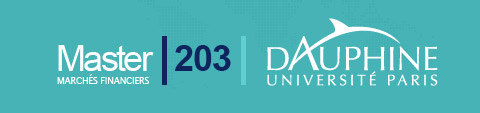

# ML Competition & Project

## I - Introduction project and features:

The main objective of the project is to study the given data and use it in order to estimate the prices of the short term electricity futures(24h).
However, putting aside the already high difficulty level of this task considering we're dealing with electricity prices, specifities of the dataset as well as the lack of  information will make it very difficult for us to have accurate predictions.

We'll start by exploring the dataset and the nature of the features we're dealing with. 

Throughout the notebook, in order to compare predictions to the target, we will compare their distribution as well as their cumulative sum. The later isn't a natural go-to technique but we think that using the cumulative sum on a "de_indexed" series will give us a good, precise and concrete visulisation of the data series.

#### Loading modules  

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import copy

import statsmodels.api as sm
import xgboost as xgb
from sklearn.linear_model import LassoCV
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_predict
from scipy.stats import spearmanr
from sklearn.metrics import mean_squared_error


import warnings
warnings.filterwarnings("ignore")

#### All the used functions


In [5]:
def export_ens(df_test, pred_test, save=True, path_save="y_test_prediction.csv"):
    """
    Export submissions with the good ENS data challenge format.
    df_test : (pandas dataframe) test set
    proba_test : (numpy ndarray) prediction as a numpy ndarray you get using method .predict()
    save : (bool) if set to True, it will save csv submission in path_save path.
    path_save : (str) path where to save submission.
    return : dataframe for submission
    """
    df_submit = pd.Series(pred_test, index=df_test.index, name="TARGET")
    df_submit.to_csv(path_save, index=True)
    return df_submit

def check_test(result, expected, display_error):
    """
    Testing your results.
    """
    if result == expected:
        print("1 test passed.")
    else:
        print(display_error)

def features_to_correct(df):
    res = []
    filtered = []
    for col in df.columns:
        if not df[[col]][df[col].isna()].empty:
            for i in df[[col]][df[col].isna()].index:
                if i not in filtered:
                    filtered.append(i)
    return filtered

# Signal creation for modeling the price
def signal(df,col,time_period = 500,eps = 10,interval_around_eps=2):
    """
    Returns a DataFrame with booleans & a string: 
    
    True: value equivalent to a value that is much higher than the mean 
    recorded in the previous observations + eps + interval_around_eps

    Stagnant: corresponds to a stagnant evolution (an evolution around eps +/- interval_around_eps)

    False: signifies a slowdown of the evolution below the mean of 
    the observations in the previous time_period + eps - interval_around_eps
    """
    
    res = pd.DataFrame(np.zeros((len(df),1)),index=df.index,columns=['counter'])
    for i in range(len(df)):
        if abs(col.cumsum().iloc[i]) > abs(col.cumsum().iloc[max(i-time_period,0):i].mean()) + eps + interval_around_eps:
            res.counter.iloc[i] = True
        elif abs(col.cumsum().iloc[i]) > abs(col.cumsum().iloc[max(i-time_period,0):i].mean()) + eps - interval_around_eps and abs(col.cumsum().iloc[i]) < abs(col.cumsum().iloc[max(i-time_period,0):i].mean()) + eps + interval_around_eps:
            res.counter.iloc[i] = 'stagnant'
        else:
            res.counter.iloc[i] = False
            
    return res.counter

def signal_int(df,col,time_period = 500,eps = 10):
    """
    simpler version of signal function, returns 1s and 0s depending on the current evolution: 
    
    1: value equivalent to a value that is much higher than the mean 
    recorded in the previous observations + eps 
    
    0: signifies a slowdown of the evolution below the mean of 
    the observations in the previous time_period + eps
    """
    
    res = pd.DataFrame(np.zeros((len(df),1)),index=df.index,columns=['counter'])
    for i in range(len(df)):
        res.counter.iloc[i] = int(abs(col.cumsum().iloc[i]) > abs(col.cumsum().iloc[max(i-time_period,0):i].mean()) + eps)
    return res.counter

def trend_divider(df,mask,signal=False):
    """
    if signal = True -> returns a list with the order of trues and falses in the analysed dataframe:
    if signal = False -> returns a list of dataframes seperating the trues from the falses 
        -> end up with a list of dataframe with each containing trues or falses keeping 
        the original indexes 
    
    mask: is a the output of the signal function and is used to seperate the original dataframe into smaller datasets
    """
    # 
    
    # initialize variables
    start_index = 0
    current_mask = mask.iloc[0]
    dataframes = []

    # iterate through rows and create new dataframes when mask changes
    for i in range(1, len(mask)):
        if mask.iloc[i] != current_mask:
            new_df = df.iloc[start_index:i]
            if signal == True:
                dataframes.append(new_df.iloc[0])
            else:
                dataframes.append(new_df)
            start_index = i
            current_mask = mask.iloc[i]

    # create final dataframe
    new_df = df.iloc[start_index:]
    if signal:
        dataframes.append(new_df.iloc[0])
    else:
        dataframes.append(new_df)
    
    
    return dataframes


def regression(trends,trend_signal,y_train_val,col,col_index,
               prediction_x_data = pd.DataFrame([]),time_period = 500, eps = 10):
    """
    Takes as input the split up dataframes as well as if its Trues or Falses, the Target, 
        the considered most important column (or set of columns), and if the user wants to
        have a prediction, he needs to enter the test dataset inputs (df_test).
    
    Goes through the various trends (of True and False) in the trends input, and at each step,
    if its an upward trend (trend_signal=True): the function will fit the specified features on the target using a non_stagnant model
    if its not (trend_signal=False): the function calls another model, the stagnant model and fits the input on the target.
    
    We end up with two models:
        -> a stagnant model which is a simple linear regression fitted using all the selected features on the target
        -> a non_stagnant model which is also a linear regression, fitting the specific feature(s) on the target
    
    Later on, we will analyse the specific feature(s) in the test set, extract the trends, and following these trends,
    we predict using the stagnant or non stagnant model.
    
    Returns a prediction on the y feature using the train set if no test set is input in the parameters
    otherwise, it will return a prediction of y using the test set features.
    
    """
    
    pred = []
    stagnant = LinearRegression()
    non_stagnant = LinearRegression()

    for i in range(len(trends)):
        idx = trends[i].index
        df = trends[i].reset_index(drop=True)
        if not trend_signal[i]:
            stagnant_model = stagnant.fit(df, y_train_val.filter(idx))
            pred_train = stagnant_model.predict(df)
            pred_train = pd.Series(pred_train, index=y_train_val.filter(idx).index)
            pred.append(pred_train)
        else:
            non_stagnant_model = non_stagnant.fit(df[col], y_train_val.filter(idx))
            pred_train = non_stagnant_model.predict(df[col])
            pred_train = pd.Series(pred_train, index=y_train_val.filter(idx).index)
            pred.append(pred_train)
    pred_train = pd.concat(pred,axis=0,ignore_index=True)
    
    if not prediction_x_data.empty:
        pred_t = []
        x_test = prediction_x_data
        best_interval = best_cushion(x_test,x_test[col[col_index]],np.arange(0.1,10,0.1))
        signal_series = signal(x_test,x_test[col[col_index]],time_period,eps,interval_around_eps=best_interval)
        trends = trend_divider(x_test,signal_series)
        trend_signal = trend_divider(signal_series,signal_series,signal=True)
        
        for i in range(len(trends)):
            idx = trends[i].index
            df = trends[i].reset_index(drop=True)
            if not trend_signal[i]: 
                pred_test = stagnant_model.predict(df)
                pred_test = pd.Series(pred_test, index=idx)
                pred_t.append(pred_test)
            else:
                pred_test = non_stagnant_model.predict(df[col])
                pred_test = pd.Series(pred_test, index=idx)
                pred_t.append(pred_test)
                

        pred_test = pd.concat(pred_t,axis=0,ignore_index=True)
    
    if not prediction_x_data.empty:
        return pred_test  
    else:
        return pred_train

def best_cushion(df,col,range_cushion):
    """
    Tests for multiple values of intervals around eps.
    
    The objective is to find the interval value that minimizes the total nb of trends.
    """
    res = {}
    min_nb = 10
    for i in range_cushion:
        signal_series = signal(df,col,time_period=500,eps=10,interval_around_eps=i)
        ref = [len(i) for i in trend_divider(df,signal_series)]
        nb = sum([ref.count(i) for i in range(1,7)])
        ref_idx = 0
        if nb < min_nb:
            min_nb = nb
            ref_idx = i
            ref_list = ref
    return range_cushion[ref_idx]


#Lasso regression
def lasso_reg(data,y_data,features_data:pd.DataFrame,features_test_data:pd.DataFrame):
    """
    simple lasso regression.
    Returns the prediction on the trainset and the prediction on the testset.
    """
    model_lasso = LassoCV(alphas=np.array([i for i in np.arange(1/1000,1,1/1000)]), fit_intercept=True, cv=20)
    results_lasso = model_lasso.fit(data,y_data.filter(features_data.index).to_numpy())

    pred = pd.Series(model_lasso.predict(features_data.to_numpy()),index=features_data.index)
    pred_test = pd.Series(model_lasso.predict(features_test_data.to_numpy()),index=features_test_data.index)
    
    return pred , pred_test

## Data Exploration

#### Loading the datasets

In [6]:
df_train = pd.read_csv(r"data\X_train_NHkHMNU.csv")
y = pd.read_csv(r"data\y_train_ZAN5mwg.csv")
df_test = pd.read_csv(r"data\X_test_final.csv")

n_rows_train = len(df_train)
n_rows_test = len(df_test)

df_train = df_train.set_index("ID")
df_y_train = y.set_index("ID")["TARGET"]
df_test = df_test.set_index("ID")

#### The distribution of the target


In [ ]:
####################### Plot the histogram #######################
plt.figure(figsize=[9, 4])
plt.hist(df_y_train)
plt.xlabel("target")
plt.ylabel("count")
plt.show()

print(df_y_train.describe())

In [ ]:
####################### Check for missing data ####################### 

missing = []
for col in df_train.columns:
    n_missing_train = df_train[col].isnull().sum()
    n_missing_test = df_test[col].isnull().sum()
    if n_missing_train != 0 or n_missing_test!=0:
        missing.append(col)
missing

In [ ]:
####################### Extract the features with missing data and plot ####################### 

filtered = features_to_correct(df_train)
filtered_test = features_to_correct(df_test)

#get list of the union of all indexes where we have some missing data
idx = pd.DataFrame(np.arange(0,len(filtered)).reshape(-1,1),index=filtered).index
idx_test = pd.DataFrame(np.arange(0,len(filtered_test)).reshape(-1,1),index=filtered_test).index

#filter and plot
df_train.filter(idx,axis=0).sort_values('DAY_ID').drop(['DAY_ID'],axis=1)[missing].reset_index(drop=True).cumsum().plot(legend=False, figsize=(15,9))
df_test.filter(idx_test,axis=0).sort_values('DAY_ID').drop(['DAY_ID'],axis=1)[missing].reset_index(drop=True).cumsum().plot(legend=False, figsize=(15,9))

In [12]:
# Fill the missing values using interpolation method
for col in df_train.drop('COUNTRY',axis=1).columns:
    df_train[col] = df_train[col].interpolate()
    df_test[col] =  df_test[col].fillna(df_test[col].mean())
    
# Interpolation doesn't work on the starting values
# We do another check and fill the remaining missing values using the mean of the feature
msg = True
for col in df_train.drop('COUNTRY',axis=1).columns:
    #first check
    n_missing_train = df_train[col].isnull().sum()
    n_missing_test = df_test[col].isnull().sum()
    if n_missing_train != 0 or n_missing_test != 0:    
        print("Column %s : missing in train set = %s / %s. In test set %s / %s" % (col, n_missing_train, df_train.shape[0], n_missing_test, df_test.shape[0]))
        print("___________________________________________________________________")
    #fill with the mean
    df_train[col] =  df_train[col].fillna(df_train[col].mean())
    df_test[col] =  df_test[col].fillna(df_test[col].mean())
    #final check
    n_missing_train = df_train[col].isnull().sum()
    n_missing_test = df_test[col].isnull().sum()
    
    if n_missing_train != 0 or n_missing_test != 0:
        msg = False
        print("Column %s : missing in train set = %s / %s. In test set %s / %s" % (col, n_missing_train, df_train.shape[0], n_missing_test, df_test.shape[0]))
if msg:
    print("No missing data anymore !")

No missing data anymore !


After having filled all the missing data, we find that our dataset contains some outliers, so we correct for observations **7 standard deviations** away from the mean

In [ ]:
for col in df_train.drop('COUNTRY',axis=1).columns:
    upper_limit = df_train[col].mean() + 7*df_train[col].std()
    lower_limit = df_train[col].mean() - 7*df_train[col].std()
    for j in df_train.index:
        if df_train[col].loc[j] > upper_limit or df_train[col].loc[j] < lower_limit :
            df_train[col].loc[j] = df_train[col].mean()

for col in df_test.drop('COUNTRY',axis=1).columns:
    upper_limit = df_test[col].mean() + 7*df_test[col].std()
    lower_limit = df_test[col].mean() - 7*df_test[col].std()
    for j in df_test.index:
        if df_test[col].loc[j] > upper_limit or df_test[col].loc[j] < lower_limit :
            df_test[col].loc[j] = df_test[col].mean()
            
df_train.filter(idx,axis=0).sort_values('DAY_ID').drop(['DAY_ID'],axis=1)[missing].reset_index(drop=True).cumsum().plot(legend=False, figsize=(15,9))
df_test.filter(idx_test,axis=0).sort_values('DAY_ID').drop(['DAY_ID'],axis=1)[missing].reset_index(drop=True).cumsum().plot(legend=False, figsize=(15,9)) 

### II - Features Engineering

We first started with the main features, checked how much of the variance its explaining.

We start by adding the FR_RENEWABLE, DE_RENEWABLE features we already worked with in class. we then use the same logic to add the rest of the energy sources taking into account their ratios: we end up with the FR_OTHER and DE_OTHER.

We will later on explore other features that could be useful such as:
- Computing a feature that contains a weighing of the consumption of each country
- Since Wind and Rain are zone related features, we created a feature containing the sum of both countries for each feature
- Exponential features

*! - We get rid of the mean for all the features keeping only the variations.*

We then analyze features individually vs the target in order to assess if they're more helpful to us in their linear, squared or exponential form.


In [14]:
# Features related to energy sources
df_train["FR_RENEWABLE"]            = ((df_train.FR_SOLAR/df_train.FR_SOLAR.mean())*0.0216 + (df_train.FR_WINDPOW*0.0634/df_train.FR_WINDPOW.mean())).fillna(0)
df_test["FR_RENEWABLE"]             = ((df_test.FR_SOLAR/df_test.FR_SOLAR.mean())*0.0216 + (df_test.FR_WINDPOW*0.0634/df_test.FR_WINDPOW.mean())).fillna(0)

df_train["DE_RENEWABLE"]            = ((df_train.DE_SOLAR/df_train.DE_SOLAR.mean())*0.09 + (df_train.DE_WINDPOW/df_train.DE_WINDPOW.mean())*0.204).fillna(0)
df_test["DE_RENEWABLE"]             = ((df_test.DE_SOLAR/df_test.DE_SOLAR.mean())*0.09 + (df_test.DE_WINDPOW/df_test.DE_WINDPOW.mean())*0.204).fillna(0)

df_train["FR_OTHER"]                = ((df_train.FR_NUCLEAR/df_train.FR_NUCLEAR.mean()) *0.7058 + (df_train.FR_HYDRO/df_train.FR_HYDRO.mean())*0.1116 + (df_train.FR_GAS/df_train.FR_GAS.mean())*0.0718 ).fillna(0)
df_test["FR_OTHER"]                 = ((df_test.FR_NUCLEAR/df_test.FR_NUCLEAR.mean()) *0.7058 + (df_test.FR_HYDRO/df_test.FR_HYDRO.mean())*0.1116 + (df_test.FR_GAS/df_test.FR_GAS.mean())*0.0718 ).fillna(0)

df_train["DE_OTHER"]                = ((df_train.DE_NUCLEAR/df_train.DE_NUCLEAR.mean()) *0.117 + (df_train.DE_COAL/df_train.DE_COAL.mean())*0.234 + (df_train.DE_LIGNITE/df_train.DE_LIGNITE.mean())*0.234 ).fillna(0)
df_test["DE_OTHER"]                 = ((df_test.DE_NUCLEAR/df_test.DE_NUCLEAR.mean()) *0.117 + (df_test.DE_COAL/df_test.DE_COAL.mean())*0.234 + (df_test.DE_LIGNITE/df_test.DE_LIGNITE.mean())*0.234 ).fillna(0)

##### A - First we want to have an idea on the correlation between the features themselves and the features vs the target

In [ ]:
corr_df = copy.deepcopy(df_train)
corr_df['y'] = df_y_train

corr = corr_df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(13, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1., center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

#### B - Regressing different versions of the features with the target

This representation allows us to first get an idea on the relationship of each feature with the target on multiple levels: linear, quadratic and exponential.

At first the idea was to only get the 1st order. However, after checking the results of these & manually checking the graphs of each features, we decided to add the 2nd order in order to catch some hidden variations.

Then again, after another round of checkups, we find features which contained some very stagnant values / very limited variations. This is why we add a comparison of the exponential of the features vs the target (with a first order linear regression)

Throughout these comparisons, we use the $R^{2}$ estimate from the score function to have an idea on the usefulness of each feature

In [ ]:
############### <!> careful not to rerun it once the exp features are added ####################
############################## Takes some time to compute (10mn) ! #############################

model = LinearRegression()
y = df_y_train
fig, axs = plt.subplots(len(df_train.drop(['DAY_ID','COUNTRY'],axis=1).columns), 3, figsize=(15, 100))
dic = {}

for idx_col,col in enumerate(df_train.drop(['DAY_ID','COUNTRY'],axis=1).columns):
   
    X = df_train[col].values.reshape(-1,1)
    model.fit(X, y)
    
    # Plot a linear regression
    r_sq = model.score(X, y)
    dic[f'{col}'] = r_sq
    sns.regplot(x=X, y=y, x_ci = 95, order=1, line_kws={"color": "red"}, ax=axs[idx_col,0])
    axs[idx_col,0].set_title(f"Regression on {col} with $100 x R^{2}$:" +  str(round(100*r_sq,2)))
    axs[idx_col,0].set(xlabel=col, ylabel="TARGET")
   
    # Plot a polynomial (order 2) regression
    r_sq = model.score(X**2, y)
    dic[f'{col}_2'] = r_sq
    sns.regplot(x=X, y=y, x_ci = 95, order=2, label = " $100 x R^{2}$ :" +  str(round(100*r_sq,2)) + "$", line_kws={"color": "red"}, ax=axs[idx_col,1])
    axs[idx_col,1].set_title(f"Regression Order 2 with $100 x R^{2}$ :" +  str(round(100*r_sq,2)))
    axs[idx_col,1].set(xlabel=col, ylabel="TARGET")
    
    X = np.exp(X)
    # Plot an exponential regression
    r_sq = model.score(X, y)
    dic[f'{col}_exp'] = r_sq
    sns.regplot(x=X, y=y, x_ci = 95, order=1, label = " $100 x R^{2}$ :" +  str(round(100*r_sq,2)) + "$", line_kws={"color": "red"}, ax=axs[idx_col,2])
    axs[idx_col,2].set_title(f"Regression exp(X) with $100 x R^{2}$ :" +  str(round(100*r_sq,2)))
    axs[idx_col,2].set(xlabel=col, ylabel="TARGET")
   
plt.tight_layout()
plt.show()

-> We add weather features cumulating the features of each country

-> We select the features that manifest a good $R^{2}$ in their exponential form vs the target and we add such their exponentials as features

In [17]:
df_train["relative_CONSUMPTION"]    = (0.5164 * (df_train.DE_CONSUMPTION /df_train.DE_CONSUMPTION.mean()) + 0.4835 * (df_train.FR_CONSUMPTION/df_train.FR_CONSUMPTION.mean())).fillna(0.)
df_test["relative_CONSUMPTION"]     = (0.5164 * (df_test.DE_CONSUMPTION/df_test.DE_CONSUMPTION.mean()) + 0.4835 * (df_test.FR_CONSUMPTION/df_test.FR_CONSUMPTION.mean())).fillna(0.)
df_train["CUM_WINDPOW"]             = ((df_train.DE_WINDPOW/df_train.DE_WINDPOW.mean()) + (df_train.FR_WINDPOW/df_train.FR_WINDPOW.mean())).fillna(0.)
df_test["CUM_WINDPOW"]              = ((df_test.DE_WINDPOW/df_test.DE_WINDPOW.mean()) + (df_test.FR_WINDPOW/df_test.FR_WINDPOW.mean())).fillna(0.)
df_train["CUM_WIND"]                = ((df_train.DE_WIND/df_train.DE_WIND.mean()) + (df_train.FR_WIND/df_train.FR_WIND.mean())).fillna(0.)
df_test["CUM_WIND"]                 = ((df_test.DE_WIND/df_test.DE_WIND.mean()) + (df_test.FR_WIND/df_test.FR_WIND.mean())).fillna(0.)
df_train["CUM_RAIN"]                = ((df_train.DE_RAIN/df_train.DE_RAIN.mean()) + (df_train.FR_RAIN/df_train.FR_RAIN.mean())).fillna(0.)
df_test["CUM_RAIN"]                 = ((df_test.DE_RAIN/df_test.DE_RAIN.mean()) + (df_test.FR_RAIN/df_test.FR_RAIN.mean())).fillna(0.)
df_train["CUM_TEMP"]                = ((df_train.DE_TEMP/df_train.DE_TEMP.mean()) + (df_train.FR_TEMP/df_train.FR_TEMP.mean())).fillna(0.)
df_test["CUM_TEMP"]                 = ((df_test.DE_TEMP/df_test.DE_TEMP.mean()) + (df_test.FR_TEMP/df_test.FR_TEMP.mean())).fillna(0.)


df_train["EXP_exchange"]            = np.exp(df_train.DE_FR_EXCHANGE)
df_train["EXP_DE_GAS"]              = np.exp(df_train.DE_GAS)
df_train["EXP_FR_GAS"]              = np.exp(df_train.FR_GAS)
df_train["EXP_DE_NUCLEAR"]          = np.exp(df_train.DE_NUCLEAR)
df_train["EXP_FR_NUCLEAR"]          = np.exp(df_train.FR_NUCLEAR)
df_train["EXP_DE_LIGNITE"]          = np.exp(df_train.DE_LIGNITE)
df_train["EXP_DE_RAIN"]             = np.exp(df_train.DE_RAIN)
df_train["EXP_FR_RAIN"]             = np.exp(df_train.FR_RAIN)


df_test["EXP_exchange"]             = np.exp(df_test.DE_FR_EXCHANGE)
df_test["EXP_DE_GAS"]               = np.exp(df_test.DE_GAS)
df_test["EXP_FR_GAS"]               = np.exp(df_test.FR_GAS)
df_test["EXP_DE_NUCLEAR"]           = np.exp(df_test.DE_NUCLEAR)
df_test["EXP_FR_NUCLEAR"]           = np.exp(df_test.FR_NUCLEAR)
df_test["EXP_DE_LIGNITE"]           = np.exp(df_test.DE_LIGNITE)
df_test["EXP_DE_RAIN"]              = np.exp(df_test.DE_RAIN)
df_test["EXP_FR_RAIN"]              = np.exp(df_test.FR_RAIN)

### III- Features selection and the various attempts at price modelling

The first step for us will be to use the previously found results($R^{2}$ results, correlation heatmap) in order to start a very early features selection.

Then we will use the spearmann correlation in order to check if the selected features hold some explanative power

We end up still with a lot of features, some of which are most likely correlated or even highly correlated. 

In order to deal with this colinearity issue, we will start by regressing each of the features vs all of our features and identify the highly correlated features.
-> this approach can be very labor intensive and requires a lot of manipulations and tweeking in order to have some correct results.

We will proceed by using the seaborn Pairplot function in order to have a complete comparison for each feature vs all the others. This will allow us to:
- Identify colinear features
- Have a visual on the distribution of each feature

In [ ]:
####################### Careful with this cell, might take too long (1h) #######################

initial_features = df_train.drop('DAY_ID',axis=1).columns
corr_df = copy.deepcopy(df_train[initial_features])
corr_df['y'] = df_y_train
sns.pairplot(corr_df[initial_features],hue='COUNTRY')

We start by picking the features ourselves for a simple linear regression model.

The main logic for picking the features is as follows:
- We pick the FR_CONSUMPTION since it contains nearly the same info as the target
- We pick one EXCHANGE feature since they're both symetric
- the DE_NET_EXPORT and FR_NET_EXPORT since they contain important info on the exports of each country (and imports since symetric)
- Energy related features with Renewable and other energy sources
- other features that we thought might add some explanative power

In [ ]:
x_train = df_train[['FR_CONSUMPTION', 'DE_FR_EXCHANGE', 'DE_NET_EXPORT', 
                    'FR_NET_EXPORT', 'DE_RAIN', 'FR_HYDRO','DE_RESIDUAL_LOAD',
                    'FR_RENEWABLE', 'DE_RENEWABLE', 'FR_OTHER', 'DE_OTHER']]

x_test = df_test[['FR_CONSUMPTION', 'DE_FR_EXCHANGE', 'DE_NET_EXPORT', 
                    'FR_NET_EXPORT', 'DE_RAIN', 'FR_HYDRO','DE_RESIDUAL_LOAD',
                    'FR_RENEWABLE', 'DE_RENEWABLE', 'FR_OTHER', 'DE_OTHER']]

clf = LinearRegression()
pred_val = cross_val_predict(clf, x_train, df_y_train)
pred_val = pd.Series(pred_val, index=df_y_train.index)

data_df = x_train.to_numpy()

# Ridge regression
model_ridge = RidgeCV(alphas=np.array([i for i in np.arange(1/1000,1,1/1000)]), fit_intercept=True, cv=20)
results_ridge = model_ridge.fit(data_df,df_y_train.to_numpy())

pred_train = pd.Series(model_ridge.predict(x_train.to_numpy()),index=x_train.index)
pred_test = pd.Series(model_ridge.predict(x_test.to_numpy()),index=x_test.index) 

plt.plot(pred_train.reset_index(drop=True).cumsum(),'b') 
plt.plot(pred_val.reset_index(drop=True).cumsum())
plt.plot(df_y_train.reset_index(drop=True).cumsum(),'g')
plt.show()

plt.plot(pred_test.reset_index(drop=True).cumsum())

 Countinuing with the same logic : 

We get rid of the highly colinear features (leaving only one). We then perform a simple lasso regression in order to get rid of the hidden correlations between the features and end up with only the "uncorrelated" features that are most helpful in simulating the target.

In [21]:
data_df = df_train[initial_features].drop('COUNTRY',axis=1).to_numpy()

# Lasso regression for factor sensitivities
model_lasso = LassoCV(alphas=np.array([i for i in np.arange(1/1000,1,1/1000)]), fit_intercept=True, cv=20)
results_lasso = model_lasso.fit(data_df,df_y_train.to_numpy())

# Key features selected by the Lasso model
lasso_selection = pd.DataFrame([results_lasso.coef_],index=['lasso'],columns=df_train[initial_features].drop('COUNTRY',axis=1).columns)
lasso_factors = lasso_selection.T[lasso_selection.T != 0].dropna().index.values

The particularity with a Lasso regression is that it allows us to get rid of some features entirely but it also makes the model not so rigid in terms of features: **one small change in the model/observations can cause the Lasso regression to change the chosen features.** So our use here of the lasso allows us to get rid of the non necessary features. 

Now that we have the selected features, we will use them in a Ridge regression in order to have a regression that **uses all of these features and that is robust in terms of used features**.

In [ ]:
x_train = df_train[lasso_factors]
x_test = df_test[lasso_factors]

clf = LinearRegression()
pred_val = cross_val_predict(clf, x_train, df_y_train)
pred_val = pd.Series(pred_val, index=df_y_train.index)

data_df = x_train.to_numpy()

# Ridge regression using all the factors selected by the Lasso
model_ridge = RidgeCV(alphas=np.array([i for i in np.arange(1/1000,1,1/1000)]), fit_intercept=True, cv=20)
results_ridge = model_ridge.fit(data_df,df_y_train.to_numpy())

pred_train = pd.Series(model_ridge.predict(x_train.to_numpy()),index=x_train.index)
pred_test = pd.Series(model_ridge.predict(x_test.to_numpy()),index=x_test.index)

plt.plot(pred_train.reset_index(drop=True).cumsum(),'b')
plt.plot(pred_val.reset_index(drop=True).cumsum(),'r')
plt.plot(df_y_train.reset_index(drop=True).cumsum(),'g')
plt.show()

plt.plot(pred_test.reset_index(drop=True).cumsum())


We give a quick try to the XGBoost library and fearing that it will take a lot of time to calibrate such model -> we decided to give up on this approach

In [ ]:
seventy_percent_data = int(0.7 * len(x_train))
x_train_set = x_train[:seventy_percent_data]
x_val = x_train[seventy_percent_data:]
y_train_set = df_y_train[:seventy_percent_data]
y_val = df_y_train[seventy_percent_data:]

# XGBOOST
# linear regression

reg = xgb.XGBRegressor(n_estimators= 1000, early_stopping_rounds=50, learning_rate = 0.01)
reg.fit(x_train_set, y_train_set, eval_set=[(x_train_set, y_train_set), (x_val, y_val)], verbose=50)
pred_train = reg.predict(x_train)
pred_train = pd.Series(pred_train, index=df_y_train.index)

plt.plot(pred_train.reset_index(drop=True).cumsum(),'b')
plt.plot(pred_val.reset_index(drop=True).cumsum())
plt.plot(df_y_train.reset_index(drop=True).cumsum(),'g')
plt.show()

Then, after checking the features, we noticed that some of these had similar patterns as the target and so, we had the idea to create a signal based on some of these features and try to fit the model around them.

The main **hypothesis** is that a big portion of the variations in the target are caused by a single feature(or a very limited nb of features)

The logic is as follows:
- We choose a single feature (or multiple features: list of features)
- We go along the path of the feature and check if it gets out of a fixed interval around its current observation:
    - if the difference between the evolution of the feature and the previous mean evolution is above a certain treshold (eps + cushion) we return True
    - if its between (eps + cushion) and (eps - cushion) then we consider it to be stagnant
    - otherwise we return False
    -> the states True and False represents the states of the feature where its explosive and where its not.
- Now that we have our "signal", we use it to perform various linear regressions alternating between states where we regress on all our features and other states where we regress only on the single feature.

We obtain the following results:

In [ ]:
x_train = df_train[['FR_CONSUMPTION', 'DE_FR_EXCHANGE', 'DE_NET_EXPORT', 
                    'FR_NET_EXPORT', 'DE_RAIN', 'FR_HYDRO','DE_RESIDUAL_LOAD',
                    'FR_RENEWABLE', 'DE_RENEWABLE', 'FR_OTHER', 'DE_OTHER']]

x_test = df_test[['FR_CONSUMPTION', 'DE_FR_EXCHANGE', 'DE_NET_EXPORT', 
                    'FR_NET_EXPORT', 'DE_RAIN', 'FR_HYDRO','DE_RESIDUAL_LOAD',
                    'FR_RENEWABLE', 'DE_RENEWABLE', 'FR_OTHER', 'DE_OTHER']]

best_interval = best_cushion(x_train,x_train.FR_CONSUMPTION,np.arange(0.1,10,0.1))
signal_series = signal(x_train,x_train.FR_CONSUMPTION,time_period=500,eps=10,interval_around_eps=best_interval)
trends = trend_divider(x_train,signal_series)
trend_signal = trend_divider(signal_series,signal_series,signal=True)

pred_train = regression(trends,trend_signal,df_y_train,col=['FR_CONSUMPTION','FR_HYDRO'],col_index=0)
pred_test = regression(trends,trend_signal,df_y_train,col=['FR_CONSUMPTION','FR_HYDRO'],col_index=0,prediction_x_data = x_test)
pred_test.index=x_test.index

plt.plot(pred_train.reset_index(drop=True).cumsum(),'b')
plt.plot(pred_val.reset_index(drop=True).cumsum())
plt.plot(df_y_train.reset_index(drop=True).cumsum(),'g')
plt.show()

plt.plot(pred_test.reset_index(drop=True).cumsum())

The issue with this approach is as follows: signal ok on trainset, but is too much of an overfit and it shows on the test set results.

We will probably need to find a way to get rid of these types of classifications (maybe logistic regression on the feature's variance ?)

This approach also takes into account the data as if its a time series. bad model for the dataset we have. 

The signal in itself is very rigid and doesn't really take into account the different variations of the target: 
- we maybe will need to create a third model that takes into account the stagnant periods on their own.
- the usage of the absolute value may be false/incorrect in this scope, since usually in financial markets prices behave differently in positive vs negative performance periods.

### PCA & Variance

Keeping the same mindset of trying to capture the variance using some techniques or using a specific set of features, we decide to use the PCA on the covariance matrix of all the features.


In [ ]:
from statsmodels.multivariate.pca import PCA as PCA
from sklearn import preprocessing

x_train = df_train[['DE_CONSUMPTION', 'FR_CONSUMPTION', 'DE_FR_EXCHANGE',
       'DE_NET_EXPORT', 'FR_NET_EXPORT', 'DE_RAIN', 'FR_RAIN',
       'DE_RESIDUAL_LOAD', 'FR_RESIDUAL_LOAD','DE_RENEWABLE','FR_RENEWABLE',
       'CUM_WINDPOW', 'FR_OTHER', 'DE_OTHER']]

x_test = df_test[['DE_CONSUMPTION', 'FR_CONSUMPTION', 'DE_FR_EXCHANGE',
       'DE_NET_EXPORT', 'FR_NET_EXPORT', 'DE_RAIN', 'FR_RAIN',
       'DE_RESIDUAL_LOAD', 'FR_RESIDUAL_LOAD','DE_RENEWABLE','FR_RENEWABLE',
       'CUM_WINDPOW', 'FR_OTHER', 'DE_OTHER']]

cov = x_train.cov()
test_cov = x_test.cov()

nb_fact = 3

####################### Train Set #######################
y = preprocessing.scale(cov.to_numpy())
pca_out=PCA((y))
pca_comp=pca_out.factors
pca_eval=pca_out.eigenvals
pca_var=pca_eval/np.sum(pca_eval)
plt.bar(np.arange(len(pca_var)),pca_var)
plt.show()

print(sum(pca_var[:nb_fact]))
x_variance_factors = pca_comp.T[:nb_fact]

####################### Test Set #######################
y = preprocessing.scale(test_cov.to_numpy())
pca_out=PCA((y))
pca_comp=pca_out.factors
pca_eval=pca_out.eigenvals
pca_var=pca_eval/np.sum(pca_eval)
plt.bar(np.arange(len(pca_var)),pca_var)
plt.show()

print(sum(pca_var[:nb_fact]))
test_variance_factors = pca_comp.T[:nb_fact]

In [23]:
factors = np.zeros((len(x_variance_factors),len(x_train)))
test_factors = np.zeros((len(test_variance_factors),len(x_test)))
for i in range(len(x_variance_factors)):
    factors[i,:] = np.dot(x_variance_factors[i,:],x_train.to_numpy().T)
    test_factors[i,:] = np.dot(test_variance_factors[i,:],x_test.to_numpy().T)

# Ridge regression to model the covariance of the target using ALL the PCA features
model_ridge = RidgeCV(alphas=np.array([i for i in np.arange(1/1000,1,1/1000)]), fit_intercept=True, cv=20)
results_ridge = model_ridge.fit(factors.T,df_y_train.to_numpy()-df_y_train.mean())

y_variance_pred = model_ridge.predict(factors.T)
variance_pred = model_ridge.predict(test_factors.T)


# Lasso regression to model the mean variations of the target using the most useful features
model_ridge = LassoCV(alphas=np.array([i for i in np.arange(1/1000,1,1/1000)]), fit_intercept=True, cv=20)
results_ridge = model_ridge.fit(x_train.to_numpy(),df_y_train.to_numpy()-df_y_train.std())

y_trend_pred = model_ridge.predict(x_train.to_numpy())
trend_pred = model_ridge.predict(x_test.to_numpy())


# Set all the data in a dataframe for the next and final regression
df_data = pd.Series(y_trend_pred, name='trend',index=df_y_train.index).to_frame()
df_data['variance'] = y_variance_pred

df_test_data = pd.Series(trend_pred, name='trend',index=x_test.index).to_frame()
df_test_data['variance'] = variance_pred

In [ ]:
# Ridge regression to make sure to use all the created features
model_ridge = RidgeCV(alphas=np.array([i for i in np.arange(1/1000,1,1/1000)]), fit_intercept=True, cv=7)
results_ridge = model_ridge.fit(df_data.to_numpy(),df_y_train.to_numpy())

pred_train = pd.Series(model_ridge.predict(df_data.to_numpy()),index=df_data.index)
pred_test = pd.Series(model_ridge.predict(df_test_data.to_numpy()),index=df_test_data.index)


plt.plot(pred_train.reset_index(drop=True).cumsum(),'b')
plt.plot(pred_val.reset_index(drop=True).cumsum())
plt.plot(df_y_train.reset_index(drop=True).cumsum(),'g')
plt.show()

plt.plot(pred_test.reset_index(drop=True).cumsum())

This approach has its merits, but I think that we are losing a lot of the information hidden in the data by going through so many transformations.

It would be a better idea to do a different split, minimize the number of transformations and reintegrate the created features back into the final model which will be used for the predictions.

We now decide to opt for a split per country, the features are selected using previous results. We apply two different Lasso regressions to the two datasets and then regroup everything using a ridge regression along with some other key features.

In [ ]:
de_train = copy.deepcopy(df_train[df_train.COUNTRY == 'DE'].drop('COUNTRY',axis=1))
fr_train = copy.deepcopy(df_train[df_train.COUNTRY == 'FR'].drop('COUNTRY',axis=1))

de_test = copy.deepcopy(df_test[df_test.COUNTRY == 'DE'].drop('COUNTRY',axis=1))
fr_test = copy.deepcopy(df_test[df_test.COUNTRY == 'FR'].drop('COUNTRY',axis=1))


fr_df_features = fr_train[['FR_HYDRO', 'EXP_FR_NUCLEAR', 'DE_FR_EXCHANGE',
       'DE_NET_EXPORT', 'FR_NET_IMPORT', 'FR_COAL', 'COAL_RET', 'CUM_WINDPOW', 'CUM_WIND']]
de_df_features = de_train[['EXP_DE_LIGNITE', 'EXP_DE_RAIN', 'FR_TEMP',
 'FR_NET_EXPORT', 'DE_NET_EXPORT', 'FR_RAIN',
 'FR_DE_EXCHANGE', 'EXP_DE_GAS', 'DE_COAL',
 'FR_RESIDUAL_LOAD', 'CUM_WINDPOW', 'CUM_WIND']]

fr_test_features = fr_test[['FR_HYDRO', 'EXP_FR_NUCLEAR', 'DE_FR_EXCHANGE',
       'DE_NET_EXPORT', 'FR_NET_IMPORT', 'FR_COAL', 'COAL_RET', 'CUM_WINDPOW', 'CUM_WIND']]
de_test_features = de_test[['EXP_DE_LIGNITE', 'EXP_DE_RAIN', 'FR_TEMP',
 'FR_NET_EXPORT', 'DE_NET_EXPORT', 'FR_RAIN',
 'FR_DE_EXCHANGE', 'EXP_DE_GAS', 'DE_COAL',
 'FR_RESIDUAL_LOAD', 'CUM_WINDPOW', 'CUM_WIND']]

fr_data = fr_df_features.to_numpy()
de_data = de_df_features.to_numpy()

fr_pred, fr_pred_test = lasso_reg(fr_data,df_y_train,fr_df_features,fr_test_features)
de_pred, de_pred_test = lasso_reg(de_data,df_y_train,de_df_features,de_test_features)


# Selected features that will be added to the final model
features = ['FR_DE_EXCHANGE', 'DE_NET_EXPORT', 'FR_RENEWABLE',
        'FR_HYDRO', 'FR_NUCLEAR', 'DE_SOLAR', 'DE_WINDPOW',
        'FR_WINDPOW','DE_RAIN', 'DE_NUCLEAR', 'FR_COAL',
        'CUM_RAIN','DE_COAL']


last = df_train[features]
last_test = df_test[features]

last['pred'] = np.nan
last_test['pred'] = np.nan

#goes through all the rows and checks if its in the FR or the DE predictions and replaces with its value
for i in last.index:
    if i in list(fr_pred.index):
        last['pred'].loc[i] = fr_pred.loc[i]
    elif i in list(de_pred.index):
        last['pred'].loc[i] = de_pred.loc[i]
else:
    print("Allocated all values to their appropriate indexes successfully !")

for i in last_test.index:
    if i in list(fr_pred_test.index):
        last_test['pred'].loc[i] = fr_pred_test.loc[i]
    elif i in list(de_pred_test.index):
        last_test['pred'].loc[i] = de_pred_test.loc[i]
else:
    print("Allocated all values to their appropriate indexes successfully !")
    

model_ridge = RidgeCV(alphas=np.array([i for i in np.arange(1/1000,1,1/1000)]), fit_intercept=True, cv=20)
results_ridge = model_ridge.fit(last.to_numpy(),df_y_train.to_numpy())

pred_train = pd.Series(model_ridge.predict(last.to_numpy()),index=last.index)
pred_test = pd.Series(model_ridge.predict(last_test.to_numpy()),index=last_test.index)

plt.plot(pred_train.reset_index(drop=True).cumsum(),'b')
plt.plot(pred_val.reset_index(drop=True).cumsum())
plt.plot(df_y_train.reset_index(drop=True).cumsum(),'g')
plt.show()

plt.plot(pred_test.reset_index(drop=True).cumsum())

## IV - Final Run

We were hoping that the previous model would score the best, but sadly, it didn't. 

And so, we decide to go for a simple ridge regression using a set of selected features from previous results and see where it will take us.

In [ ]:
# Selected features 
features = ['FR_DE_EXCHANGE', 'DE_NET_EXPORT', 'FR_RENEWABLE',
            'FR_HYDRO', 'FR_NUCLEAR', 'DE_SOLAR', 'DE_WINDPOW',
            'FR_WINDPOW','DE_RAIN', 'DE_NUCLEAR', 'FR_COAL',
            'CUM_RAIN','DE_COAL']

last = df_train[features]
last_test = df_test[features]

model_ridge = RidgeCV(alphas=np.array([i for i in np.arange(1/1000,1,1/1000)]), fit_intercept=True, cv=20)
results_ridge = model_ridge.fit(last.to_numpy(),df_y_train.to_numpy())

pred_train = pd.Series(model_ridge.predict(last.to_numpy()),index=last.index)
pred_test = pd.Series(model_ridge.predict(last_test.to_numpy()),index=last_test.index)

plt.plot(pred_train.reset_index(drop=True).cumsum(),'b')
plt.plot(pred_val.reset_index(drop=True).cumsum())
plt.plot(df_y_train.reset_index(drop=True).cumsum(),'g')
plt.show()

plt.plot(pred_test.reset_index(drop=True).cumsum())

In [ ]:
df=(pred_test).to_frame(name='test').reset_index(drop=True)
df['train'] = (pred_train).to_frame().reset_index(drop=True)
df['y'] = df_y_train.reset_index(drop=True)
sns.pairplot(df)


In [ ]:
# Compute Spearman Rank Correlation
spearman_train = spearmanr(df_y_train, pred_train)
print("Spearman rank score on train dataset : %.4f" % (spearman_train.correlation))

# MSE
mse_train = mean_squared_error(pred_train, df_y_train)
print("MSE score on train dataset : %.4f" % mse_train)

We notice similarities between the distribution of the target and that of the test set. And given the results (MSE & Spearman), we can say that this model can effectively predict with at least 20% accuracy.

## V - Interpretation & Conclusion

Throughout this challenge, we took various approaches, some returned better results, but the overall challenge was very instructive.

We started with a simple linear regression, penalized regressions, signals, used PCA factors as inputs in penalized regressions. We also corrected the data, got rid of all the outliers and used interpolation to fill the missing values.

The various tried approches were explained and sadly didn't perform very well. We had to resort to simple approches in the end that surprisingly returned better results.

-> This raises the question of why ? 
The reasons can be related to the dataset being obscure, not being a timeseries, not having more info on the data. Maybe the entire approach we had in feature selection wasn't correct and that maybe we needed to rank the observations given their values and analyse them starting from there.